# **IDENTIFICATION OF POTENTIAL BIOMARKERS FOR EARLY-STAGE HEPATOCELLULAR CARCINOMA**

## Introduction

Hepatocellular carcinoma (HCC) is a leading cause of cancer-related deaths globally (Yang et al., 2019), often diagnosed at an advanced stage when treatment options are limited and less effective (Shi et al., 2021). Early detection of HCC is crucial to improving patient outcomes, yet the current biomarkers, such as Alpha-fetoprotein (AFP), lack the specificity and sensitivity needed for reliable early-stage diagnosis (Luo et al., 2019).
A Critical early hallmark of HCC is the dedifferentiation of the adult hepatocytes into fetal-like cells. Therefore, the upregulation of fetal-like cells in adult liver tissues could indicate early-stage HCC (Suhail et al., 2018).

### Scope of the Study

This study focuses on exploring how to identify these potential biomarkers by analysing gene expression across various datasets. Specifically, it involves comparing fetal liver datasets with those from normal liver tissues, HCC tumor tissues, and adjacent non-tumor tisuues. Identifying genes common to these datasets could uncover potential markers for early-stage HCC.

### Objectives

1. Identify differentially expressed genes (DEGs) in HCC and normal liver tissue samples.
2. Compare fetal liver gene expression to other groups to detect upregulated fetal genes in adults.
3. Conduct enrichment pathway analysis to pinpoint genes and pathways linked to early-stage HCC.

### Significance and Impact of the Study

By systematically exploring the dedifferention process and fetal gene expression in adults, this study aims to outline a robust approach to identify biomarkers that could improve early detection of HCC.

### Hypotheses

1. There is a difference in gene expression levels between normal liver tissue and HCC tumor tissue, with specific genes upregulated in early-stage HCC that may serve as potential biomarkers.

2. The dedifferentiation of adult hepatocytes into a state resembling fetal liver cells is a hallmark of early-stage HCC, leading to the upregulation of fetal genes in adult HCC tumor tissues. 

## Methodology

This study aims to identify potential biomarkers for early-stage HCC by analysing various microarray gene expression datasets. The process involves comparing gene expression in different groups and using bioinformatics tools to identify key patterns. 

### Data Collection and Study Grouping

**Data Source**: Microarray gene expression datasets were retrieved from the Gene Expression Omnibus (GEO) database. The datasets were divided into four main groups: 

|Groups|Datasets|Accession_Number|
|-----|--------|-----------------|
|1. Annotated early-stage HCC samples|75 tissue samples with 8 HCV induced HCC stages and normal liver as control|GSE6764|
|                                 |107 samples of 9 HCC stages with adjacent non-tumor tissue as control|GSE89377|
|2. Comparison of healthy liver tissues to adjacent non-tumor tissues of HCC|22 tumor samples, 19 adjacent non-tumor samples, 2 pooled healthy liver samples from 6 healthy donors|GSE14520|
|3. Identification of DEGs from HCC tumor tissues and adjacent non-tumor tissues|HCC samples, 240 tumor samples, 193 adjacent non-tumor samples|GSE36376|
|                                                                               |39 tumor samples and 30 non-tumor samples of surgicallyu resected HCC patients|GSE136247|
|4. Identification of potential tissue biomarkers for early-stage HCC|158 samples, comparing the large-scale analysis of the human and mouse transcriptome of various fetal and adult organs, 2 fetal liver samples and 2 adult liver samples|GSE1133|

### Data Processing: Log2 Transformation and Normalization

Each dataset underwent a consistent preprocessing workflow, including log2 transformation, normalization, filtering, grouping, and identification of DEGs. The process was applied to each dataset as follows:

1. Log2 Transformation: This step converts the expression values into a log scale to reduce skewness in the data distribution, making it more suitable for downstream analysis.
   
2. Quantile Normalization: The normalization between arrays function ensures that the distribution of expression values is comparable across all samples in the dataset. This step is critical for identifying DEGs.

Here, we illustrate the Log2 transformation and normalization steps with the first dataset - "Microarray dataset for annotated early-stage HCC samples (GSE6764)":

```r
# R code snippet for log2 transformation and data normaslization
#   Differential expression analysis with limma
library(GEOquery)
library(limma)
library(umap)

# load series and platform data from GEO

gset <- getGEO("GSE6764", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL570", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset)


```r
# group membership for all samples
gsms <- paste0("13333221112234444040400000441100330040044410013333",
        "3222222222222243044110444")
sml <- strsplit(gsms, split="")[[1]]

# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }
  exprs(gset) <- normalizeBetweenArrays(exprs(gset))

In [5]:
import matplotlib.pyplot as plt

In [6]:
boxplot = plt.imread('box_plot1.png')

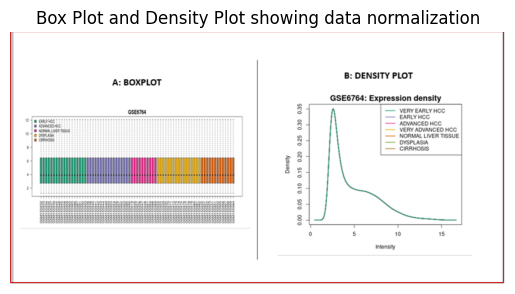

In [8]:
plt.imshow(boxplot)
plt.axis('off')
plt.title('Box Plot and Density Plot showing data normalization')
plt.show()

### Group Definition and Analysis with GEO2R

**Group Definition**: The samples were divided into specific groups (early-stage HCC, advanced HCC, normal liver tissue, Dysplasia, and cirrhosis) based on the dataset's metadate. These groups were defined using GEO2R tool to facilitate DEG analysis.

**GEO2R Analysis**: The defined groups were then analysed using GEO2R, a web based tool designed for identifying DEGs. The initial p-value was set to p <0.05 and the analysis was repeated using p <0.01 and p <0.10. This step produced various visualisations, including p-value statistics to identify significant gene expression differences between groups, UMAP plots, Venn diagrams.

```r
#This code shows the grouping setup and design matrix creation in R
# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("Advanced HCC","Normal Liver","Dysplasia","Cirrhosis","Early-stage HCC"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

gset <- gset[complete.cases(exprs(gset)), ] # skip missing values

fit <- lmFit(gset, design)  # fit linear model

```r
# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups, c(tail(groups, -1), head(groups, 1)), sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)

tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","F","GB_ACC","SPOT_ID","Gene.Symbol","Gene.symbol","Gene.title"))
write.table(tT, file=stdout(), row.names=F, sep="\t")

# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution")

# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05, lfc=0)

# Venn diagram of results
vennDiagram(dT, circle.col=palette())


```r
# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
# Please note that the code provided to generate graphs serves as a guidance to
# the users. It does not replicate the exact GEO2R web display due to multitude
# of graphical options.
# 
# The following will produce basic volcano plot using limma function:
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
  highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

# MD plot (log fold change vs mean log expression)
# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)

```r
################################################################
# General expression data analysis
ex <- exprs(gset)
# box-and-whisker plot
dev.new(width=3+ncol(gset)/6, height=5)
ord <- order(gs)  # order samples by group
palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
title <- paste ("GSE6764", "/", annotation(gset), sep ="")
boxplot(ex[,ord], boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=gs[ord])
legend("topleft", groups, fill=palette(), bty="n")
dev.off()

# expression value distribution
par(mar=c(4,4,2,1))
title <- paste ("GSE6764", "/", annotation(gset), " value distribution", sep ="")
plotDensities(ex, group=gs, main=title, legend ="topright")

```r
# UMAP plot (dimensionality reduction)
ex <- na.omit(ex) # eliminate rows with NAs
ex <- ex[!duplicated(ex), ]  # remove duplicates
ump <- umap(t(ex), n_neighbors = 15, random_state = 123)
par(mar=c(3,3,2,6), xpd=TRUE)
plot(ump$layout, main="UMAP plot, nbrs=15", xlab="", ylab="", col=gs, pch=20, cex=1.5)
legend("topright", inset=c(-0.15,0), legend=levels(gs), pch=20,
col=1:nlevels(gs), title="Group", pt.cex=1.5)
library("maptools")  # point labels without overlaps
pointLabel(ump$layout, labels = rownames(ump$layout), method="SANN", cex=0.6)

# mean-variance trend, helps to see if precision weights are needed
plotSA(fit2, main="Mean variance trend, GSE6764")

### Downloading and Filtering DEGs

**Downloading DEGs**: The list of DEGs was downloaded based on the p-values obtained from the GEO2R analysis.

**Filtering in Excel**: The DEGs for the different p-values were further filtered in Excel based on p-values and log fold change to narrow down the list of upregulated HCC genes.

The above processes were repeated using the same dataset but the groups were redefined, breaking down early-stage HCC to very early HCC and early HCC; and breaking down advanced HCC to very advanced HCC and advanced HCC to further understand the breakdown of the categories and their relationship to each other.

### Further Analysis (Enrichment Pathway Analysis)

The upregulated HCC genes were subjected to enrichment analysis to explore their biological significance, identifying key pathways associated with early-stage HCC.

The above methodology was replicated for the second, third and fourth groups in this study, respectively.

## Results Summary

Based on the 4 groups used in this study, the results were categorised in 4 groups as follows:

#### **Group 1: Microarray Studies with Annotated Early-Stage HCC Samples**

#### Normal Liver as Control

1. **UMAP Plots Analysis**: Two UMAP plots were generated from the same dataset as explained in the methodology above.
        Plot A: Merged HCC samples
        Plot B: Split HCC samples

While the UMAP plots show the separation between normal liver and HCC tissue samples, they revealed confounding factors associated with the control, as we saw early-satge HCC clustered around advanced stage HCC, making it challenging to differentiate early HCC from advanced HCC, indicating that these datasets might be less effective for early HCC identification (see UMAP plots below)

In [4]:
import matplotlib.pyplot as plt

In [5]:
umaplot = plt.imread('UMAP_plots.png')

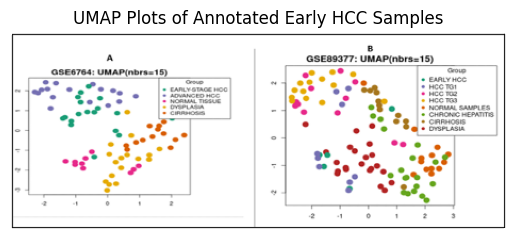

In [7]:
plt.imshow(umaplot)
plt.axis('off')
plt.title('UMAP Plots of Annotated Early HCC Samples')
plt.show()

2. **Volcano Plot Analysis**: Volcano plots were generated using different p-value thresholds to identify DEGs. The objective was to identify genes that differentiate HCC tissues from the control (normal liver tissues).

**Criteria**: P-value thresholds of <0.01 and log fold change of >_2 were primarily used to identify significant DEGs with 99% confidence level.

**Findings**: More significant genes were seen at the highest p-value threshold (0.10), as the p-value is made more stringent, the number of DEGs decreased. This is because the smaller the p-value, the more significant the genes (see volcano plots below).

In [8]:
import matplotlib.pyplot as plt

In [9]:
volcanoplot = plt.imread('volcano_plot1.png')

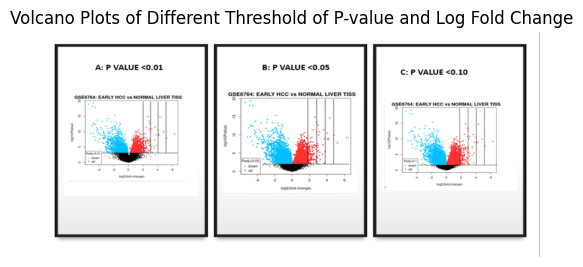

In [11]:
plt.imshow(volcanoplot)
plt.axis('off')
plt.title('Volcano Plots of Different Threshold of P-value and Log Fold Change')
plt.show()

3. **Total Number of DEGs for Different Thresholds**: A table was generated to summarise the total number of genes identified under the different thresholds of p-values and log fold changes. For p-=value <0.01 and log fold change >=2, 41 significant DEGs were identified.

|P-Value|Total DEGs|>=2 Fold change|>=3 Fold change|>=4 Fold change|>=5 Fold change|
--------|----------|---------------|---------------|---------------|---------------|
|<0.01|1586|41|4|1|1|
|<0.05|2912|32|1|0|0|
|<0.10|3775|32|1|0|0|

##### **Adjacent Non-Tumor Tissue as Control**

The findings from the first dataset (normal liver as control) suggested the need to further investigate the differences in gene expression between normal liver tissues and HCC tumor tissues. This led to the analysis of the second annotated HCC samples.

1. **UMAP Plot Analysis**: The UMAP plot for this dataset was analysed to explore the relationships between the different stages of HCC samples present in the dataset and the adjacent non-tumor tissues used as control. This analysis provided insights into distinguishing features between these groups.

Similar to the first dataset, there were no clear distinctions between early-stage and advanced HCC samples as shown in the UMAP plot below. This might be as a result of the control used in the study.

In [12]:
import matplotlib.pyplot as plt

In [13]:
umaplot2 = plt.imread('umap_plot2.png')

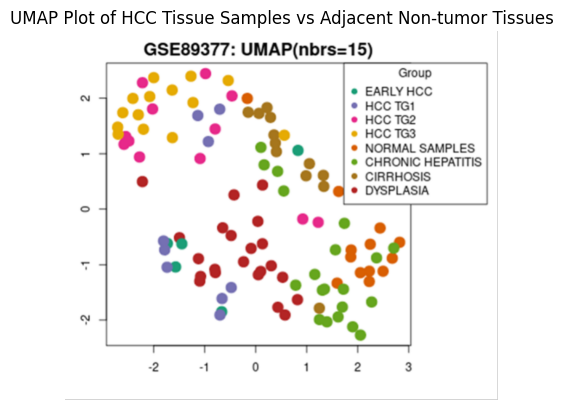

In [19]:
plt.imshow(umaplot2)
plt.axis('off')
plt.title('UMAP Plot of HCC Tissue Samples vs Adjacent Non-tumor Tissues')
plt.show()

2. **Volcano Plot Analysis**: The volcano plots identified the differential expression levels between the HCC tissue samples and the adjacent non-tumor tissues using the same criteria (p-value <0.01 and log fold change >=2). This allowed for the identification of key genes that could indicate consistent biomakers of HCC.

In [16]:
import matplotlib.pyplot as plt

In [17]:
volcanoplots2 = plt.imread('volcano_plots2.png')

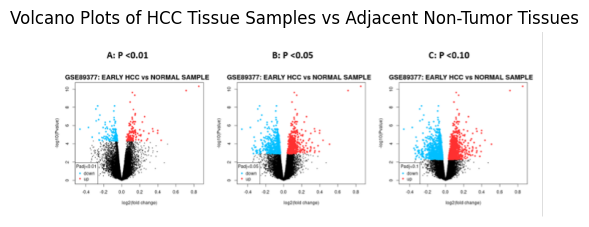

In [20]:
plt.imshow(volcanoplots2)
plt.axis('off')
plt.title('Volcano Plots of HCC Tissue Samples vs Adjacent Non-Tumor Tissues')
plt.show()

3. **Venn Diagram Analysis**: To identify common genes between the annotated early-stage HCC datasets (Group 1), a Venn diagram was used. The analysis revealed two genes (FAT1 and AKR1B10) that were common across both datasets indicating their involvement with HCC.

In [22]:
import matplotlib.pyplot as plt

In [23]:
venndiagram = plt.imread('Venn_diagram.png')

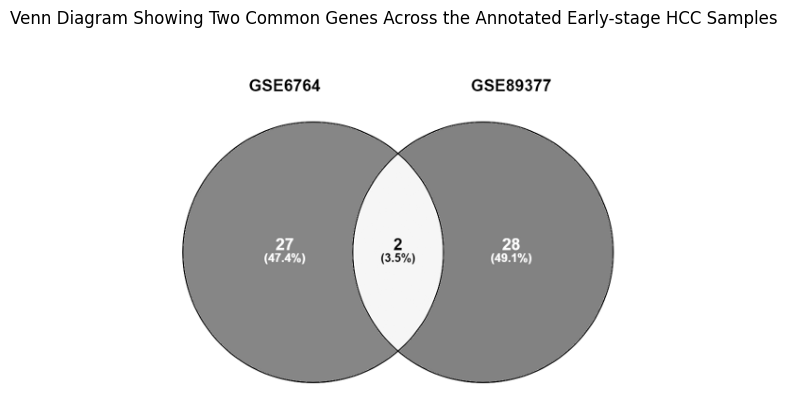

In [25]:
plt.imshow(venndiagram)
plt.axis('off')
plt.title('Venn Diagram Showing Two Common Genes Across the Annotated Early-stage HCC Samples')
plt.show()

4. **Enrichment Pathway Analysis**: The two common genes, FAT1 and AKR1B10 were subjected to enrichment pathway analysis, revealing their association with specific biological pathways and functions related to early-stage HCC.

The table below shows the enriched terms in gene ontologies associated with Jensen tissues, indicating that FAT1 and AKR1B10 are associated with liver cancer cells, adipose tissue, and natural killer cells.

|Term|P-value|Genes|
-----|-------|-----|
|Liver cancer cell|0.0016|AKR1B10|
|Lymphocytes|0.0084|FAT1|
|Natural killer cell|0.227|AKR1B10; FAT1|
|Adipose tissue|0.371|AKR1B10; FAT1|
|Liver|0.663|AKR1B10; FAT1|

In further enrichment analysis, it was found that the enriched terms for the genes in diseases/drugs associated with disgenet were Hepatitis C, liver diseases, Neoplasms, liver carcinoma, carcinogenesis, tumor progression, and more.

#### **Group 2: Comparison of Healthy Liver Tissues to Adjacent Non-Tumor Tissues of HCC**

In Group 1, we saw that the first dataset which used normal liver tissues as control was able to distinguish early HCC with a greater fold change compared to the second study which used adjacent non-tumor tissues as control. To further investigate the effectiveness of adjacent non-tumor samples as controls, another study was conducted, comparing healthy normal liver samples and adjacent non-tumor samples, as well as tumor samples of HCC.

1. **UMAP Plot Analysis**: The UMAP analysis was conducted to explore the relationship between HCC tumor samples and the adjacent non-tumor samples by investigating the effectiveness of the adjacent non-tumor samples in differentiating the tumor samples.

In the UMAP plot below, the two controls (normal healthy liver and adjacent non-tumor tissues) could be seen clustered at the top right quadrant. However, there is a wider difference between the healthy controls and the tumor samples compared to the difference between the adjacent non-tumor samples and the tumor samples.

In [26]:
import matplotlib.pyplot as plt

In [28]:
umaplot3 = plt.imread('umap_plot3.png')

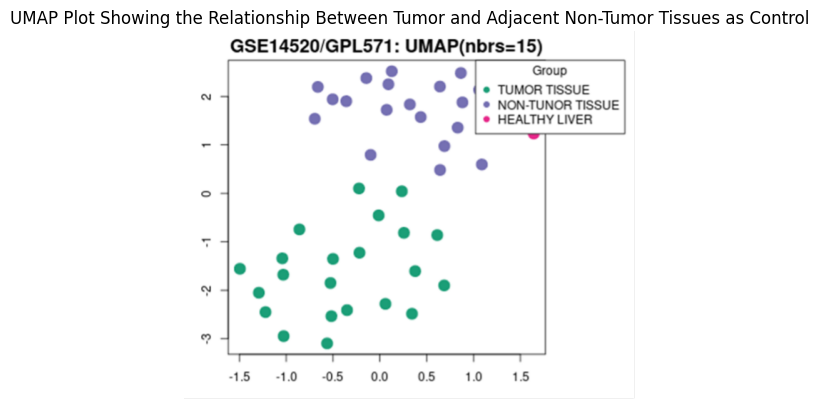

In [30]:
plt.imshow(umaplot3)
plt.axis('off')
plt.title('UMAP Plot Showing the Relationship Between Tumor and Adjacent Non-Tumor Tissues as Control')
plt.show()

2. **Volcano Plots Analysis**: The volcano plots identified the difference in the levels of differentiation between the healthy liver samples and the tumor tissues; and between the adjacent non-tumor tissues and the tumor tissues.

We can see that the highest range of fold change at a p-value of <0.01 was detected in the tumor and healthy liver contrast at 1.5 while the other two contrasts have a fold change of 1 (see below).

In [31]:
import matplotlib.pyplot as plt

In [32]:
volcanoplots4 = plt.imread('volcano_plots4.png')

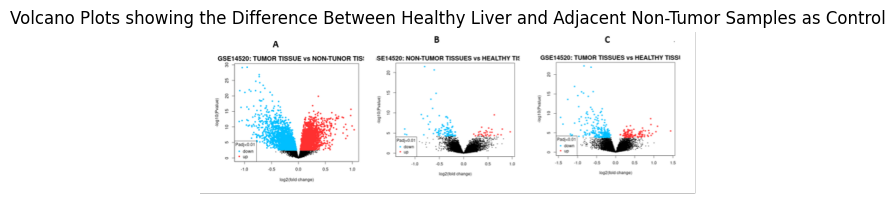

In [34]:
plt.imshow(volcanoplots4)
plt.axis('off')
plt.title('Volcano Plots showing the Difference Between Healthy Liver and Adjacent Non-Tumor Samples as Control')
plt.show()

#### **Group 3: Identification of DEGs from HCC tumor tissues and adjacent non-tumor tissues**

From the results obtained from the comparison between healthy liver samples and adjacent non-tumor samples, it could be seen that the second dataset in the annotated early-stage HCC samples did not meet the criteria to be compared to the first study for the selection of candidate biomarkers due to the differences in control and the inability of the adjacent non-tumor samples to provide a clear distinction between it and the tumor samples. Another study was then designed to identify genes that distinguish HCC tumor samples from adjacent non-tumor samples and the DEGs from that study will be used in this study.

1. **UMAP Plots Analysis**: The UMAP analysis shows the comparison between the HCC tumor and adjacent non-tumor samples to determine the genes that differentiates them.

From A, the tumor samples were majorly clustered at the bottom right quadrant while the non-tumor samples were clustered at the top left quadrant. However, clusters of the non-tumor samples were mixed with some dispersed tumor tissues at the top left quadrant. In other words, the non-tumor tissues were found in the tumor tissues.
From B, the tumor tissues from the top right quadrant were seen transcending towards the non-tumor tissues at the bottom left quadrant, two samples of the tumor tissues were found in the non-tumor tissues and the margin between the tumor and non-tumor tissues is very thin (see UMAP plot below).

In [35]:
import matplotlib.pyplot as plt

In [36]:
umaplot5 = plt.imread('umap_plot5.png')

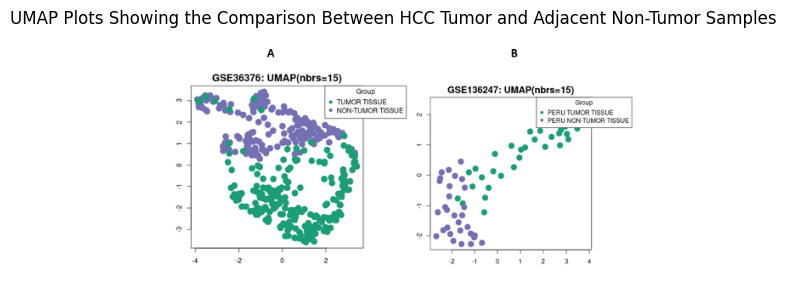

In [38]:
plt.imshow(umaplot5)
plt.axis('off')
plt.title('UMAP Plots Showing the Comparison Between HCC Tumor and Adjacent Non-Tumor Samples')
plt.show()

2. **Volcano pLots Analysis**: The volcano plots were used to show the differential levels between the tumor and non-tumor samples.
As not much difference was seen between the tumor and non-tumor samples, the selection criteria for this section was changed to a p-value threshold of <0.05 to increase the number of DEGs obtained from the datasets.

The volcano plots below show the range of log fold change with respect to the p-value. From A, the highest log fold change at p-value <0.05 is 0.6.
From B, it is slightly above 1.0. A total of 24,771 DEGs were obtained from A and 27,394 from B but none had up to 2-fold difference. The DEGs were selected down to a 0.5-fold change for A and 0.25 for B as only 2 genes were above 0.5. A total of 36 genes were recovered from A and 16 from B. 

In [39]:
import matplotlib.pyplot as plt

In [40]:
volcanoplots5 = plt.imread('volcano_plots5.png')

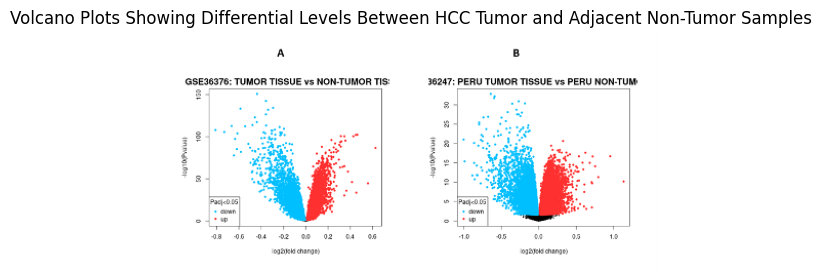

In [41]:
plt.imshow(volcanoplots5)
plt.axis('off')
plt.title('Volcano Plots Showing Differential Levels Between HCC Tumor and Adjacent Non-Tumor Samples')
plt.show()

3. **Venn Diagram Analysis**: To determine the genes that differentiates HCC tumor samples from non-tumor samples, the 3 datasets containing these samples were analysed using a Venn diagram to determine common genes to all 3 DEGs.

Two genes were found unique to the 3 datasets; ACSL4 and CCL20.

In [42]:
import matplotlib.pyplot as plt

In [43]:
venndiagram = plt.imread('Venn_diagram5.png')

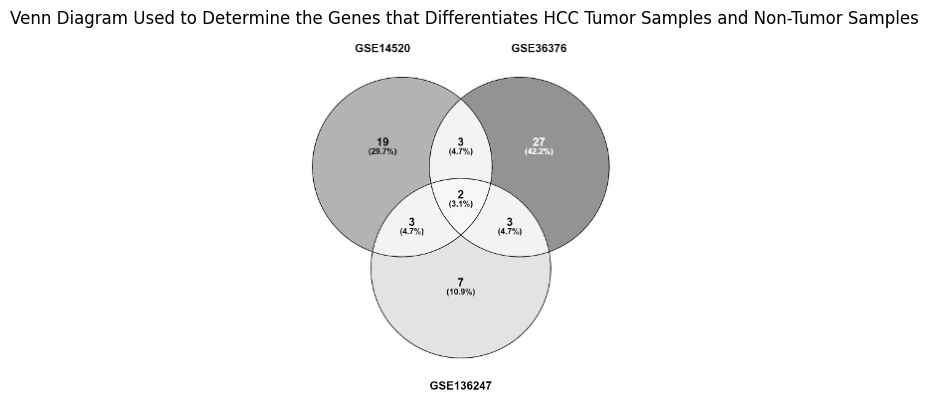

In [44]:
plt.imshow(venndiagram)
plt.axis('off')
plt.title('Venn Diagram Used to Determine the Genes that Differentiates HCC Tumor Samples and Non-Tumor Samples')
plt.show()

4. **Enrichment Analysis**: The KEGG analysis was carried out as part of the enrichment analysis.
It was revealed that CCL20 is enriched in fatty acids biosynthesis while ACSL4 is enriched in the Tumor Necrosis Factor (TNF) signalling pathway (see KEGG enrichment pathway below).
As part of the cell type, it was revealed that CCL20 is enriched in cancer cell line encyclopedia, associated with HEP3B217 Liver, HUH7 Liver, JHH7 Liver, and HEPG2 Liver. These may provide useful information, worth further investigation for early HCC biomarkers discovery.

In [45]:
import matplotlib.pyplot as plt

In [46]:
keggpathway = plt.imread('kegg_pathway.png')

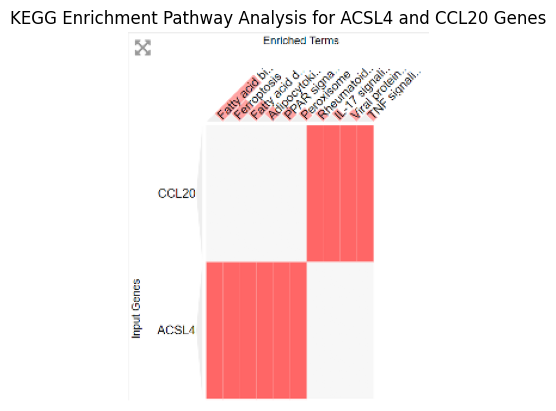

In [47]:
plt.imshow(keggpathway)
plt.axis('off')
plt.title('KEGG Enrichment Pathway Analysis for ACSL4 and CCL20 Genes')
plt.show()

#### **Group 4: Identification of potential tissue biomarkers for early-stage HCC**

From the above analysis, it could be deduced that the intersected genes from the annotated early-stage HCC datasets and the HCC tumor genes provided relevant information in relation to the study of interest. However, due to poor controls and ideal datasets which did not meet a significant criteria, it is not enough to detect potential biomarkers only from the previous datasets. 

Therefore, another study was designed to study the DEGs in fetal and adult liver and to identify the upregulated genes of the fetal liver which maybe potential biomarkers for early-stage HCC as earlier mentioned (one early hallmark of the HCC is the dedifferentiation of the adult hepatocytes into more highly proliferative hepatocytes typical of the fetal liver).

##### **Determining Upregulated Fetal Genes**

1. **UMAP Plot Analysis**: The UMAP plot below shows the relationship between fetal liver, adult liver, and other organs. Each point represents an individual sample (see UMAP plot below).

 **Key Observations**
Clustering of fetal liver and adult liver samples: The plot reveals that fetal liver and adult liver samples are positioned closely together in the UMAP space, suggesting a similarity in their gene expression profiles. This observation is significant in the context of the HCC as one of the early hallmarks of HCC is the dedifferentiation of the adult hepatocytes into a more proliferative state similar to the fetal liver cells.

Separation from other organs: The distinct separation between liver samples (fetal and adult) and other organs underscores the unique gene expression patterns specific to the liver tissues. This distinction supports the study's focus on liver-specific markers for early-stage HCC detection.

Context within the study: The proximity of fetal liver and adult liver samples aligns with the hypothesis that adult liver cells in early-stage HCC may exhibit a fetal-like gene expression profile. This clustering indicates the potential involvement of upregulated fetal genes in the progression of HCC. Identifying these genes could provide crucial insights into biomarkers for early-stage HCC.

In [48]:
import matplotlib.pyplot as plt

In [49]:
umapplot6 = plt.imread('umap_plot6.png')

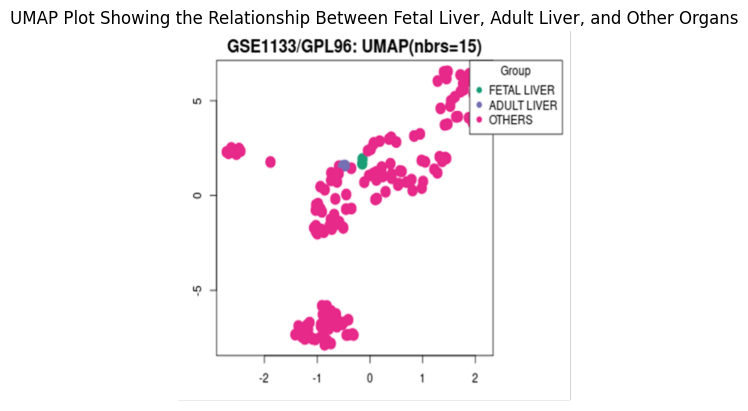

In [51]:
plt.imshow(umapplot6)
plt.axis('off')
plt.title('UMAP Plot Showing the Relationship Between Fetal Liver, Adult Liver, and Other Organs')
plt.show()

2. **Volcano Plot Analysis**: At a p-value of <0.01, the fetal and adult liver contrast from the volcano plot below shows that the range of the log fold change is >8, which is particularly interesting as it indicates a substantial change in expression levels and this aligns with the context of the study (see volcano plot below).

A total of 64 DEGs were recovered which are upregulated in the fetal liver.

In [52]:
import matplotlib.pyplot as plt

In [53]:
volcanoplot6 = plt.imread('volcano_plot6.png')

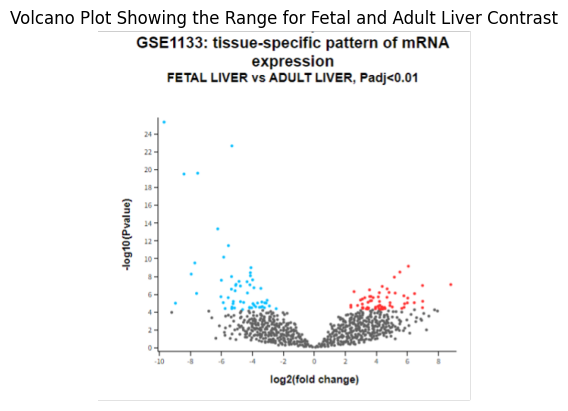

In [54]:
plt.imshow(volcanoplot6)
plt.axis('off')
plt.title('Volcano Plot Showing the Range for Fetal and Adult Liver Contrast')
plt.show()

#### **Identifying the Potential Biomarkers for Early-stage HCC**

**Annotated Early HCC DEGs vs Upregulated Fetal Genes**

To identify genes which may be potential early-stage HCC markers, the studies from the annotated early HCC samples were compared to the DEGs from upregulated fetal liver using a Venn diagram as shown below. However, no common gene was found between any of the two studies and the DEGs from the fetal and adult liver samples; the only common genes in the set are between the annotated early HCC samples (see Venn diagram below).

In [55]:
import matplotlib.pyplot as plt

In [57]:
venndiagram6 = plt.imread('Venn_diagram6.png')

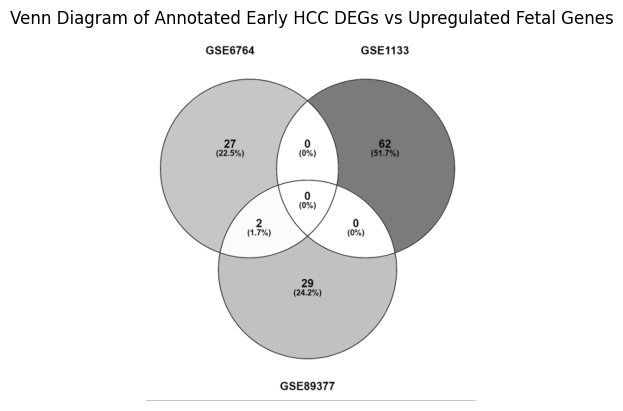

In [59]:
plt.imshow(venndiagram6)
plt.axis('off')
plt.title('Venn Diagram of Annotated Early HCC DEGs vs Upregulated Fetal Genes')
plt.show()

**Tumor and Non-Tumor DEGs vs Upregulated Fetal Genes**

Again, the DEGs from the tumor and adjacent non-tumor samples were compared to the upregulated fetal liver genes using a 4-set Venn diagram as shown below. No gene was found in common between the 4 datasets. However, 2 genes were found in common within 3 datasets, one of which is from the upregulated fetal liver genes, namely AFP (an already existing HCC biomarker) and SQLE genes. Another gene found in common between the DEGs of the HCC samples and the upregulated fetal liver genes is COL2A1 gene (see Venn diagram below).

In [60]:
import matplotlib.pyplot as plt

In [61]:
venndiagram7 = plt.imread('4-set_Venn_diagram.png')

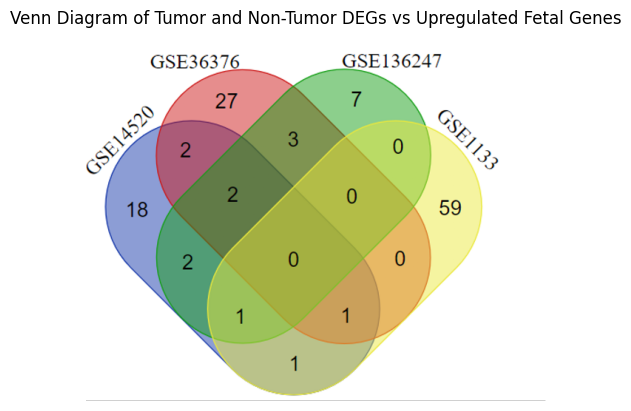

In [62]:
plt.imshow(venndiagram7)
plt.axis('off')
plt.title('Venn Diagram of Tumor and Non-Tumor DEGs vs Upregulated Fetal Genes')
plt.show()

#### **Summary of Key Findings**

The table below summarises the key genes identified in the analysis

|Datasets|Total Number of Genes|Genes Identified|
---------|---------------------|----------------|
|Annotated early HCC|2|AKR1B10; FAT1|
|Tumor and Non-tumor|2|CCL20; ACSL4|
|Upregulated fetal liver and HCC samples|3|**SQLE; AFP; COL2A1**|


#### **Enrichment Analysis of the Key Genes**

The pathway enrichment analysis of the key genes revealed that the genes are enriched in KEGG pathway associated with the WNT signalling pathway which is reponsible for cell proliferation and recognised for cancer development.
In ontologies, they are enriched in GO bioprocess associated with the positive regulation of insulin secretion and in Jensen disease associated with liver neoplasm.
In disease/drugs, they are enriched in genome-wide association studies (GWAS) associated with tumor biomarkers and in rare disease GeneRIF associated with **liver cancer and hepatocellular carcinoma** (see enrichment analysis visualisations below).

In [63]:
import matplotlib.pyplot as plt

In [67]:
enrichment_analysis = plt.imread('enrichment3.png')

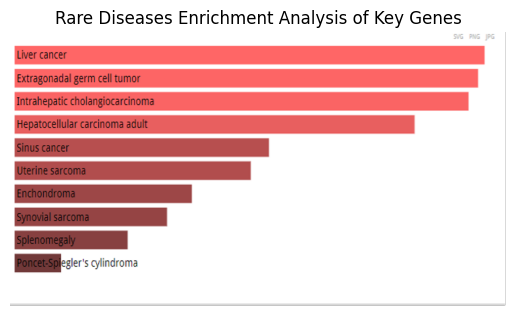

In [68]:
plt.imshow(enrichment_analysis)
plt.axis('off')
plt.title('Rare Diseases Enrichment Analysis of Key Genes')
plt.show()

## Conclusion

This study identified three key genes - **SQLE, AFP, and COL2A1**- as potential early-stage HCC biomarkers.

- **SQLE** is associated with HCC development and progression through pathways such as STRAP and TNF signalling, highlighting its role in early tumor formation (Yin et al., 2018).
- **AFP**, while already known as HCC marker, requires further exploration to determine its specificity for early-stage HCC (Luo et al., 2021).
- **COL2A1** showed promise due to its upregulation in HCC and involvement in embryonic development (Bashur et al., 2018).

The enrichment analysis supported their relevance to liver cancer pathways. Despites identifying these candidates, further research with larger datasets is needed to validate their utility in early HCC detection.

## References

- Bashur, L.A., Chen, D., Chen, Z., Liang, B., Pardi, R., Murakami, S. and Zhou, G. (2018). Loss of jab1 in osteochondral progenitor cells severely impairs embryonic limb development in mice. Journal of Cellular Physiology, [online] 229(11), pp.1607–1617. doi:10.1002/jcp.24602.image.pngimage.pngimage.pngimage.png

- Luo, P., Wu, S., Yu, Y., Ming, X., Li, S., Zuo, X. and Tu, J. (2019). Current Status and Perspective Biomarkers in AFP Negative HCC: Towards Screening for and Diagnosing Hepatocellular Carcinoma at an Earlier Stage. Pathology & Oncology Research. doi:10.1007/s12253-019-00585-5.

- Shi, J.-F., Cao, M., Wang, Y., Bai, F.-Z., Lei, L., Peng, J., Feletto, E., Canfell, K., Qu, C. and Chen, W. (2021). Is it possible to halve the incidence of liver cancer in China by 2050? International Journal of Cancer, [online] 148(5), pp.1051–1065. doi:10.1002/ijc.33313.image.pngimage.pngimage.pngimage.png

- Suhail, Y., Cain, M.P., Vanaja, K., Kurywchak, P.A., Levchenko, A., Kalluri, R. and Kshitiz (2019). Systems Biology of Cancer Metastasis. Cell Systems, [online] 9(2), pp.109–127. doi:10.1016/j.cels.2019.07.003.image.pngimage.pngimage.pngimage.png

- Yang, J.D., Hainaut, P., Gores, G.J., Amadou, A., Plymoth, A. and Roberts, L.R. (2019). A global view of hepatocellular carcinoma: trends, risk, prevention and management. Nature Reviews Gastroenterology & Hepatology, 16(10), pp.589–604. doi:10.1038/s41575-019-0186-y.image.pngimage.pngimage.pngimage.png

- Yin, W., zhang, Wu, W., Jiao, H., Chen, Y., Ji, X., Cao, J. and Yin, F. (2022). Squalene epoxidase promotes hepatocellular carcinoma development by activating STRAP transcription and TGF-β/SMAD signaling. 1. doi:10.22541/au.164201880.00585800/v1.image.pngimage.pngimage.pngimage.png
